In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

EPOCHS = 100

targets = ['_5HT2A', 'AChE', 'D2R', 'D3R', 'MAOB']
num = [1000, 2000, 5000]

dataframes = {
    target: pd.read_csv(f'../generated_molecules/{EPOCHS}-epoch/predicted_activity/{target}.csv')
    for target in targets
}

dataframes["Unconditional"] = pd.read_csv(f'../generated_molecules/{EPOCHS}-epoch/predicted_activity/Unconditional.csv')

for target in dataframes:
    df = dataframes[target]
    col_preds = df.columns[1]

    count_invalid = len(df[df[col_preds].isna()])
    print(f"{target}: {count_invalid} invalid SMILES")

    # Drop invalid smiles rows
    dataframes[target] = df.dropna(subset=[col_preds]).copy()
    # Set dtype as float for every column except SMILES
    for col in df.columns:
        if col != 'SMILES':
            dataframes[target][col] = dataframes[target][col].astype(float)

    print(dataframes[target].shape)

_5HT2A: 2192
(27808, 10)
AChE: 3435
(26565, 10)
D2R: 1923
(28077, 16)
D3R: 1745
(28255, 10)
MAOB: 1161
(28839, 10)
Unconditional: 2087
(27913, 25)


In [5]:
# aggs = ["SUM", "MEAN", "MAX"]
# aggs = ["MEAN", "MAX"]
aggs = ["SUM"]

multi_targets = list()

for agg in aggs:
    multi_targets.extend([
        f"AChE_MAOB_{agg}",
        f"D2R__5HT2A_{agg}",
        f"D2R_D3R_{agg}"
    ])

dataframes_mt = {
    targets: pd.read_csv(f'../generated_molecules/{EPOCHS}-epoch/predicted_activity/{targets}.csv')
    for targets in multi_targets
}

for mts in dataframes_mt:
    df = dataframes_mt[mts]

    col_preds = df.columns[1]

    count_invalid = len(df[df[col_preds].isna()])
    print(f"{mts}: {count_invalid}")

    # Drop invalid smiles rows
    dataframes_mt[mts] = df.dropna(subset=[col_preds]).copy()
    # Set dtype as float for every column except SMILES
    for col in df.columns:
        if col != 'SMILES':
            dataframes_mt[mts][col] = dataframes_mt[mts][col].astype(float)
    
    print(dataframes_mt[mts].shape)

AChE_MAOB_SUM: 2634
(27366, 10)
D2R__5HT2A_SUM: 4130
(25870, 10)
D2R_D3R_SUM: 4434
(25566, 10)


### Single-target distribution

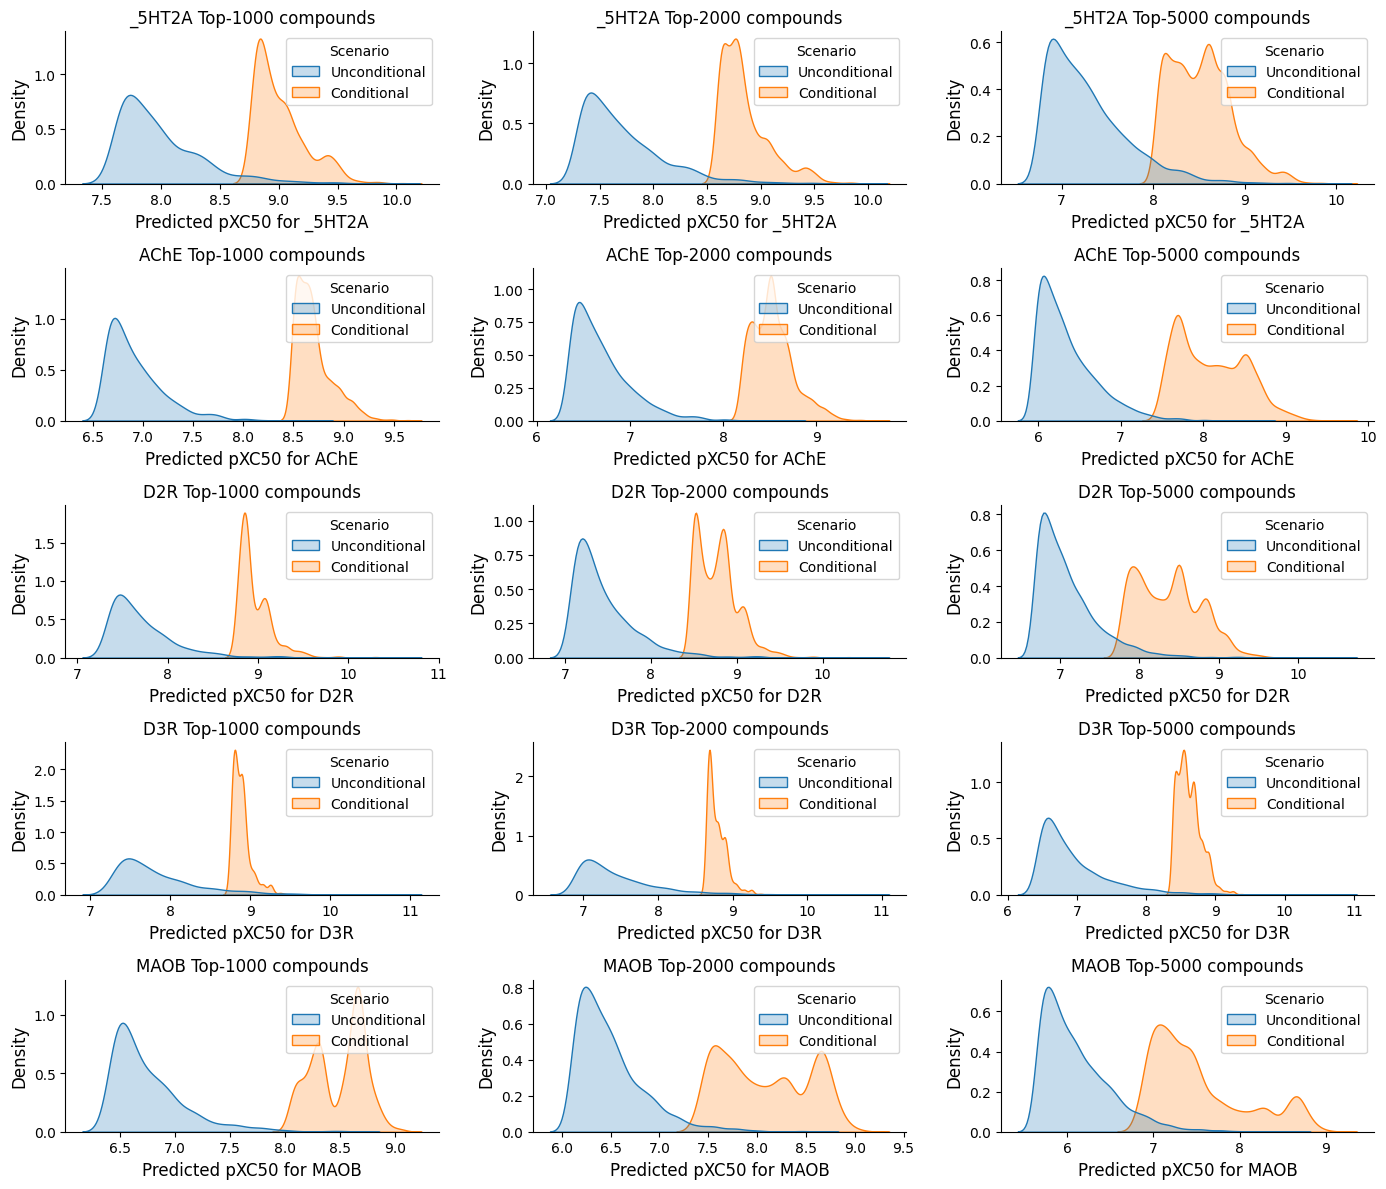

In [3]:
# ACT_TYPE = "Activity" 
# ACT_TYPE = "pIC50"
ACT_TYPE = "pXC50"
# ACT_TYPE = "inhibition"

pal=list(sns.color_palette("tab10"))
fig, axes = plt.subplots(len(targets), len(num), figsize=(14, 12))

for i, name in enumerate(targets):
    for j, n in enumerate(num):
        activity_column = f"{name}_{ACT_TYPE}"
        unconditional = dataframes["Unconditional"][
            activity_column
        ].nlargest(n).to_frame().assign(Scenario="Unconditional")

        conditional = dataframes[name][
            activity_column
        ].nlargest(n).to_frame().assign(Scenario="Conditional")

        activities = pd.concat([unconditional, conditional]).reset_index()

        sns.kdeplot(data=activities, x=activity_column, bw_adjust=1, hue='Scenario',ax=axes[i, j], fill=True)
        # sns.histplot(data=activities, x=activity_column, hue='Scenario',ax=axes[i, j], fill=True)

        axes[i, j].set_title('{} Top-{} compounds'.format(name, n), fontsize=12)
        axes[i, j].spines['right'].set_visible(False)
        axes[i, j].spines['top'].set_visible(False)
        axes[i, j].set_ylabel("Density", fontsize=12)
        axes[i, j].set_xlabel(f"Predicted {ACT_TYPE} for {name}", fontsize=12)

    plt.tight_layout()

plt.show()

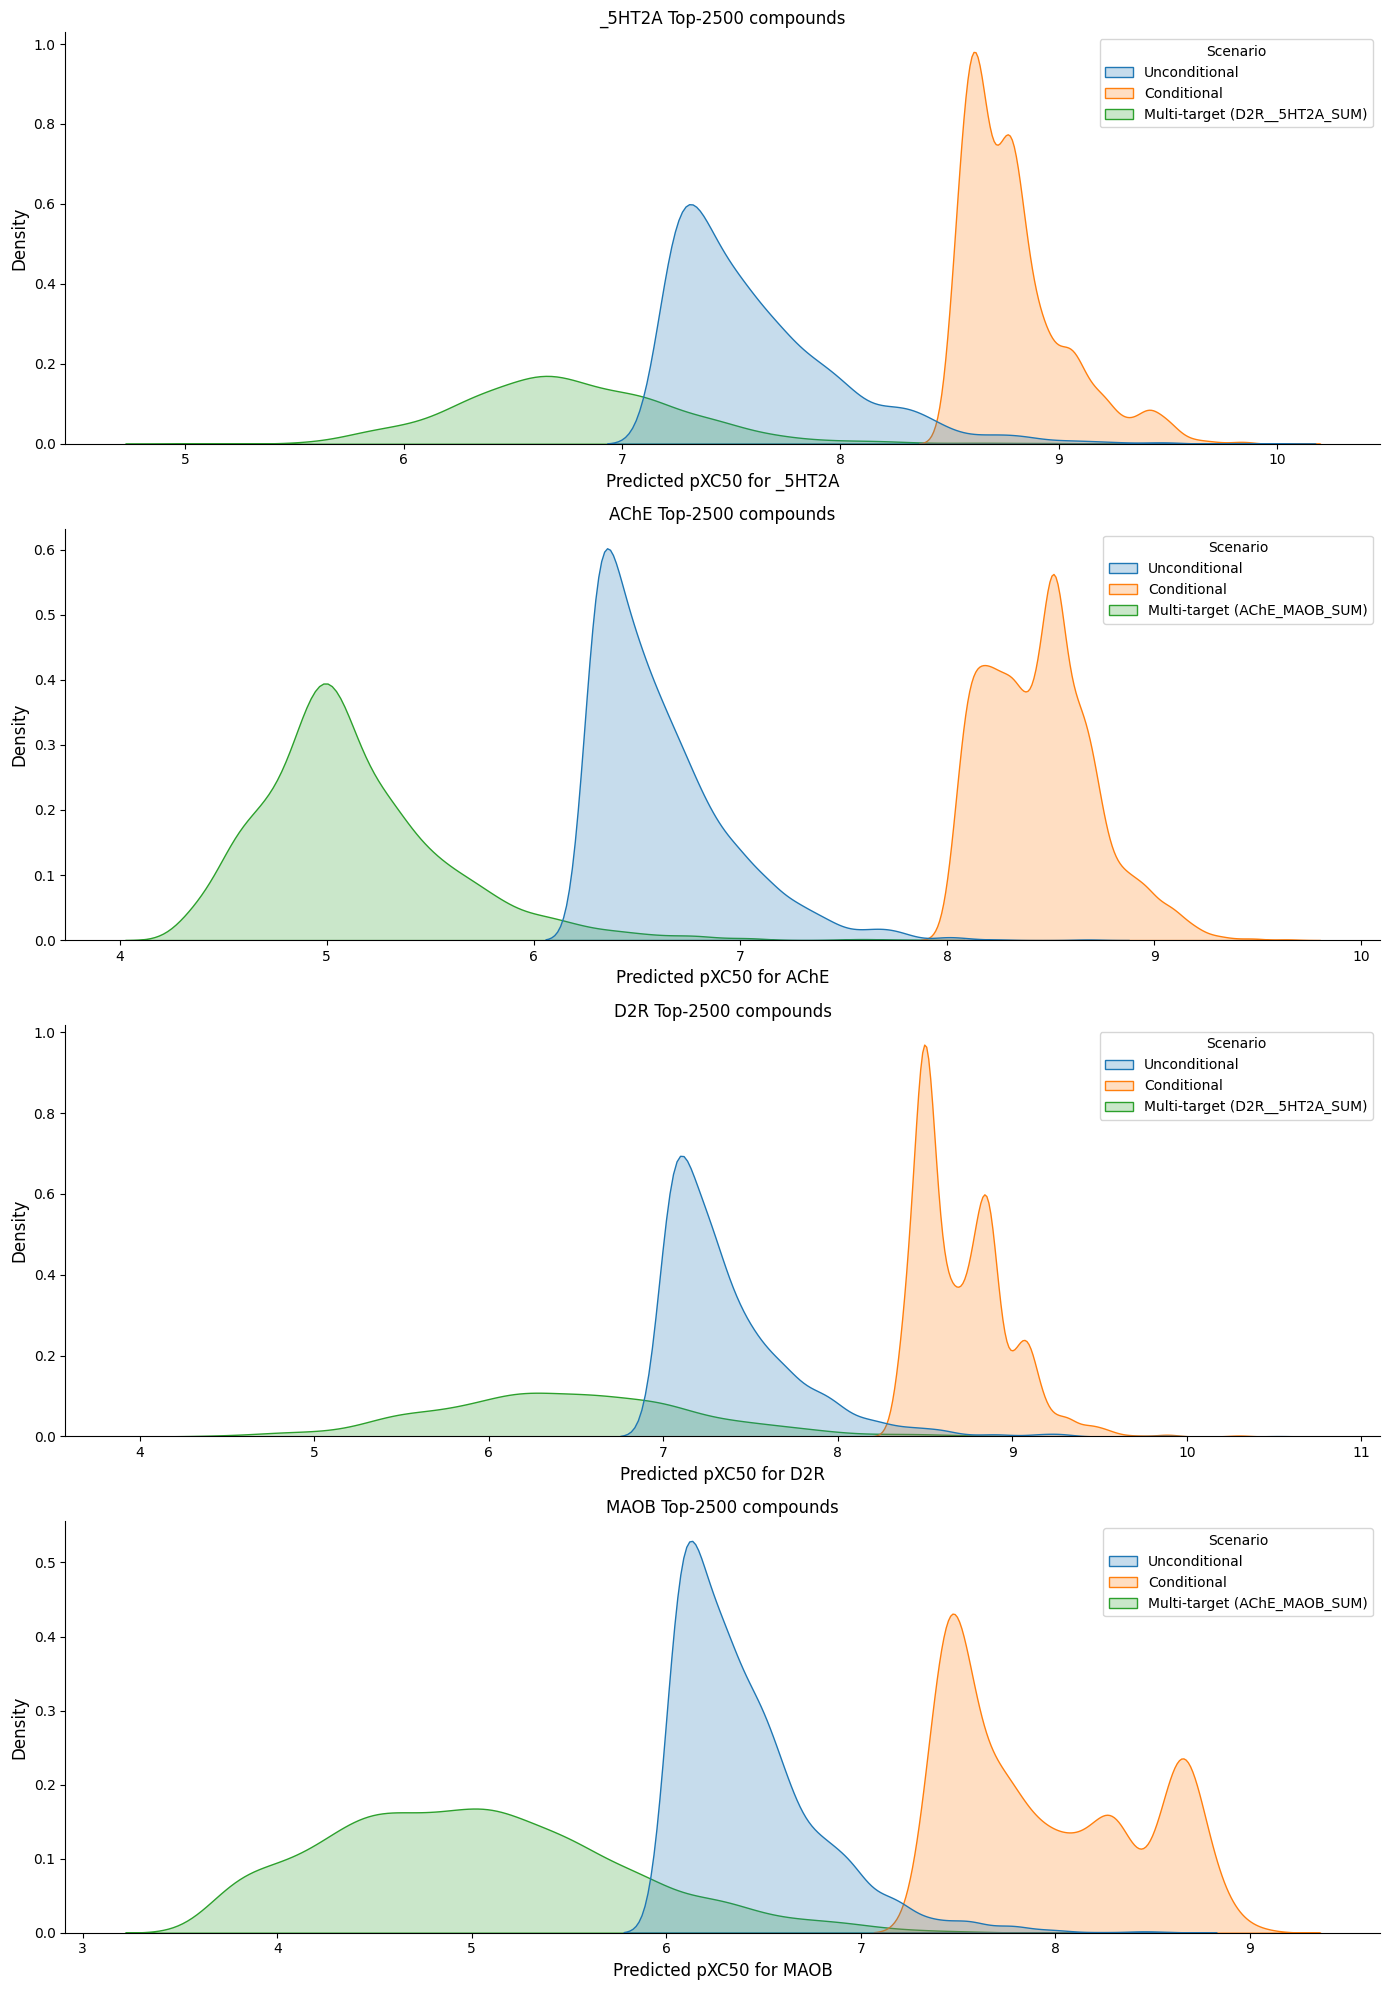

In [4]:
# Plot the multi-target distributions for the top 1000 compounds
agg = "SUM"

multi_targets = [
    f"AChE_MAOB_{agg}",
    f"D2R__5HT2A_{agg}",
    # f"D2R_D3R_{agg}"
]

# targets = ['_5HT2A', 'AChE', 'D2R', 'D3R', 'MAOB']
targets = ['_5HT2A', 'AChE', 'D2R', 'MAOB']
# targets =  ['AChE', 'MAOB']

fig, axes = plt.subplots(len(targets), 1, figsize=(14, 20))
n = 2500

for j, target in enumerate(targets):
    activity_column = f"{target}_{ACT_TYPE}"
    df_list = list()

    unconditional = dataframes["Unconditional"][
        activity_column
    ].nlargest(n).to_frame().assign(Scenario="Unconditional")

    conditional = dataframes[target][
        activity_column
    ].nlargest(n).to_frame().assign(Scenario="Conditional")

    df_list.append(unconditional)
    df_list.append(conditional)

    for mts in multi_targets:
        if target not in mts:
            continue
    
        multi_target = dataframes_mt[mts][
            activity_column
        ].nlargest(n).to_frame().assign(Scenario=f'Multi-target ({mts})')

        df_list.append(multi_target)

    activities = pd.concat(df_list).reset_index()

    sns.kdeplot(data=activities, x=activity_column, bw_adjust=1, hue='Scenario',ax=axes[j], fill=True)
    # sns.kdeplot(data=df, x="pred_pXC50", bw_adjust=1, hue='Scenario',ax=axes[j], fill=True)

    axes[j].set_title('{} Top-{} compounds'.format(target, n), fontsize=12)
    axes[j].spines['right'].set_visible(False)
    axes[j].spines['top'].set_visible(False)
    axes[j].set_ylabel("Density", fontsize=12)
    axes[j].set_xlabel(f"Predicted {ACT_TYPE} for {target}", fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
# !pip install ptitprince

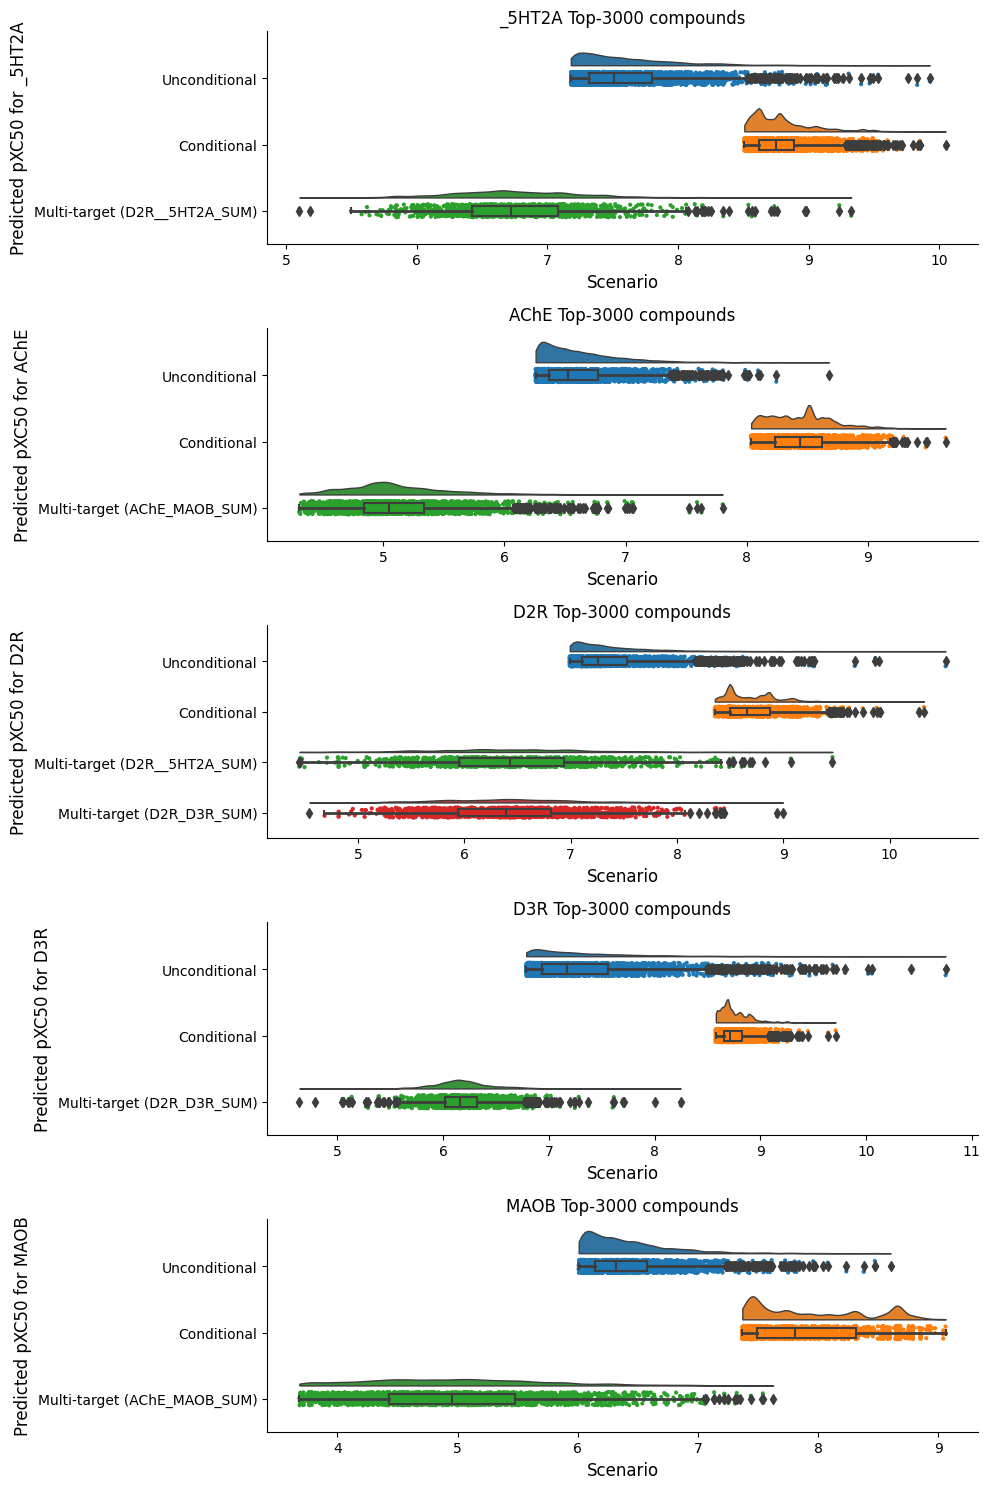

In [5]:
import ptitprince as pt

num = 3000
agg = "SUM"

multi_targets = [
    f"AChE_MAOB_{agg}",
    f"D2R__5HT2A_{agg}",
    f"D2R_D3R_{agg}"
]

targets = ['_5HT2A', 'AChE', 'D2R', 'D3R', 'MAOB']
# targets = ['_5HT2A', 'AChE', 'D2R', 'MAOB']
# targets =  ['AChE', 'MAOB']

fig, axes = plt.subplots(len(targets), figsize=(10, 15))

for i, target in enumerate(targets):
    activity_column = f"{target}_{ACT_TYPE}"
    df_list = list()

    unconditional = dataframes["Unconditional"][
        activity_column
    ].nlargest(n).to_frame().assign(Scenario="Unconditional")

    conditional = dataframes[target][
        activity_column
    ].nlargest(n).to_frame().assign(Scenario="Conditional")

    df_list.append(unconditional)
    df_list.append(conditional)

    for mts in multi_targets:
        if target not in mts:
            continue
    
        multi_target = dataframes_mt[mts][
            activity_column
        ].nlargest(n).to_frame().assign(Scenario=f'Multi-target ({mts})')

        df_list.append(multi_target)

    activities = pd.concat(df_list).reset_index()

    pt.RainCloud(data=activities, x='Scenario', y=activity_column, bw=.1, ax=axes[i], palette=pal, orient = "h")

    axes[i].set_title('{} Top-{} compounds'.format(target, num), fontsize=12)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['top'].set_visible(False)
    axes[i].set_ylabel(f"Predicted {ACT_TYPE} for {target}", fontsize=12)
    axes[i].set_xlabel("Scenario", fontsize=12)

plt.tight_layout()

plt.show()

In [15]:
for j, target in enumerate(targets):
    activity_column = f"{target}_{ACT_TYPE}"
    df_list = list()

    unconditional = dataframes["Unconditional"][
        activity_column
    ].nlargest(n).to_frame().assign(Scenario="Unconditional")

    conditional = dataframes[target][
        activity_column
    ].nlargest(n).to_frame().assign(Scenario="Conditional")

    df_list.append(unconditional)
    df_list.append(conditional)

    for mts in multi_targets:
        if target not in mts:
            continue
    
        multi_target = dataframes_mt[mts][
            activity_column
        ].nlargest(n).to_frame().assign(Scenario=f'Multi-target ({mts})')

        df_list.append(multi_target)

    activities = pd.concat(df_list).reset_index()
    pivot = activities.pivot_table(index='Scenario', values=activity_column, aggfunc=[np.mean, np.std])
    format_str = "{:.2%}" if ACT_TYPE == "Activity" else "{:.2f}"

    # print(f"Target: {target}")
    display(pivot.style
                 .format(format_str)
                 .set_caption(f"Top-{n} {target} {ACT_TYPE} statistics")
                 .background_gradient(cmap='Blues', axis=0))

,mean,std
,_5HT2A_pXC50,_5HT2A_pXC50
Scenario,,
Conditional,8.58,0.40
Multi-target (D2R__5HT2A_SUM),8.52,0.41
Unconditional,8.30,0.42


,mean,std
,AChE_pXC50,AChE_pXC50
Scenario,,
Conditional,7.23,0.44
Multi-target (AChE_MAOB_SUM),7.00,0.50
Unconditional,7.02,0.37


,mean,std
,D2R_pXC50,D2R_pXC50
Scenario,,
Conditional,8.23,0.50
Multi-target (D2R_D3R_SUM),8.04,0.50
Multi-target (D2R__5HT2A_SUM),8.09,0.46
Unconditional,7.96,0.45


,mean,std
,D3R_pXC50,D3R_pXC50
Scenario,,
Conditional,8.38,0.26
Multi-target (D2R_D3R_SUM),8.39,0.26
Unconditional,8.20,0.30


,mean,std
,MAOB_pXC50,MAOB_pXC50
Scenario,,
Conditional,7.48,0.46
Multi-target (AChE_MAOB_SUM),7.04,0.48
Unconditional,6.57,0.54


### Assess mean target modulation

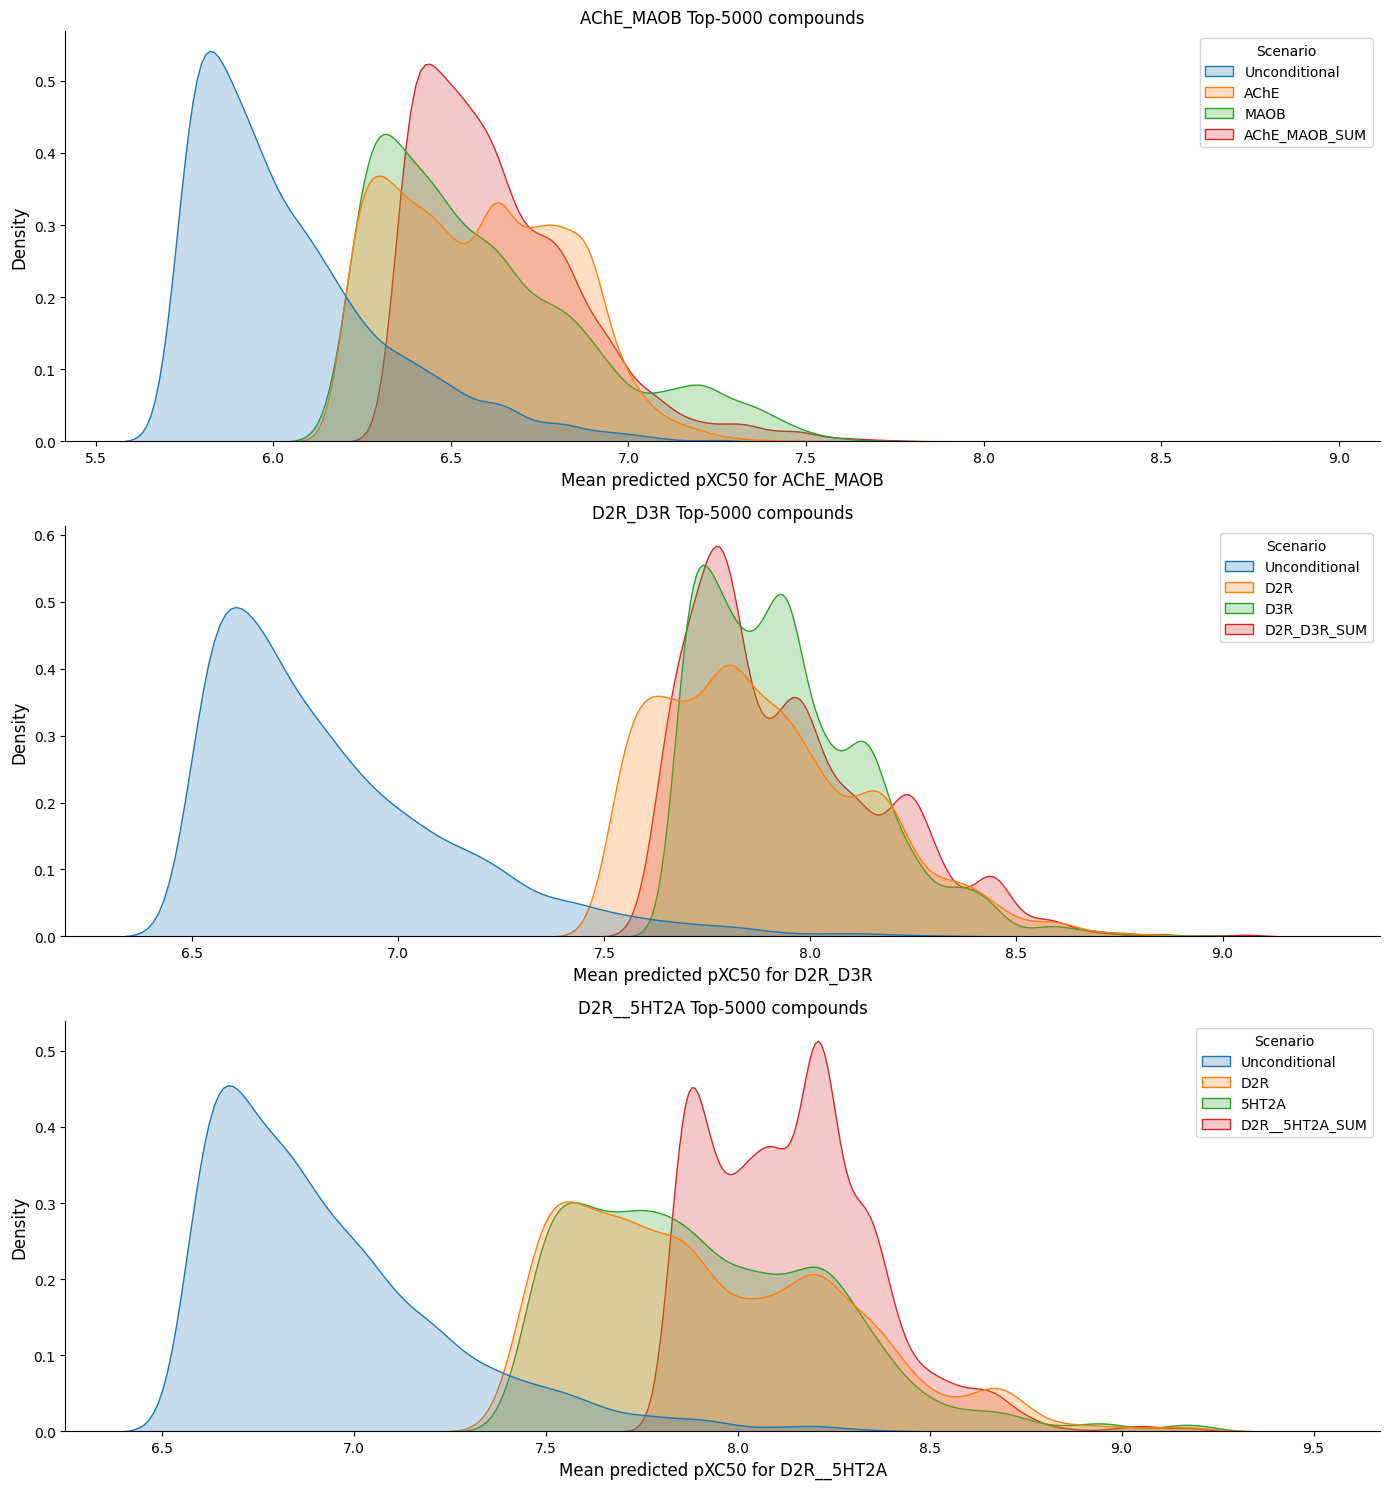

In [6]:
agg = "SUM"  # MEAN, MAX
# ACT_TYPE = "Activity"  # pIC50, inhibition
ACT_TYPE = "pXC50"  # pIC50, inhibition

multitarget_combination = {
    "AChE_MAOB": {
        "generated_molecules": ["Unconditional", "AChE", "MAOB", f"AChE_MAOB_{agg}"],
        # "generated_molecules": ["AChE", "MAOB", f"AChE_MAOB_{agg}"],
        "models": ["AChE", "MAOB"]
    },
    "D2R_D3R": {
        "generated_molecules": ["Unconditional", "D2R", "D3R", f"D2R_D3R_{agg}"],
        # "generated_molecules": [ "D2R", "D3R", f"D2R_D3R_{agg}"],
        "models": ["D2R", "D3R"]
    },
    "D2R__5HT2A": {
        "generated_molecules": ["Unconditional", "D2R", "_5HT2A", f"D2R__5HT2A_{agg}"],
        # "generated_molecules": [ "D2R", "_5HT2A", f"D2R__5HT2A_{agg}"],
        "models": ["D2R", "_5HT2A"]
    },
}

fig, axes = plt.subplots(len(multitarget_combination), 1, figsize=(14, 5 * len(multitarget_combination)))
n = 5000


for j, combination in enumerate(multitarget_combination):
    activity_column = f"{combination}_{ACT_TYPE}"
    df_list = list()
    # print(f"Combination: {activity_column}")

    gen_molecules = multitarget_combination[combination]["generated_molecules"]
    for gen_molecule in gen_molecules:
        # print(gen_molecule)
        # df = pd.read_csv(f'../generated_molecules/predicted_activity/{gen_molecule}_MTDD.csv')
        df = pd.read_csv(f'../generated_molecules/{EPOCHS}-epoch/predicted_activity/{gen_molecule}.csv')
        scenario = gen_molecule[1:] if gen_molecule.startswith("_") else gen_molecule
        df_filtered = df[activity_column].nlargest(n).to_frame().assign(Scenario=scenario)
        df_list.append(df_filtered)

    activities = pd.concat(df_list).reset_index()

    sns.kdeplot(data=activities, x=activity_column, bw_adjust=1, hue='Scenario',ax=axes[j], fill=True)
    # sns.kdeplot(data=df, x="pred_pXC50", bw_adjust=1, hue='Scenario',ax=axes[j], fill=True)

    axes[j].set_title('{} Top-{} compounds'.format(combination, n), fontsize=12)
    axes[j].spines['right'].set_visible(False)
    axes[j].spines['top'].set_visible(False)
    axes[j].set_ylabel("Density", fontsize=12)
    axes[j].set_xlabel(f"Mean predicted {ACT_TYPE} for {combination}", fontsize=12)

plt.tight_layout()
plt.show()

In [11]:
df[activity_column].isna().sum()

4130

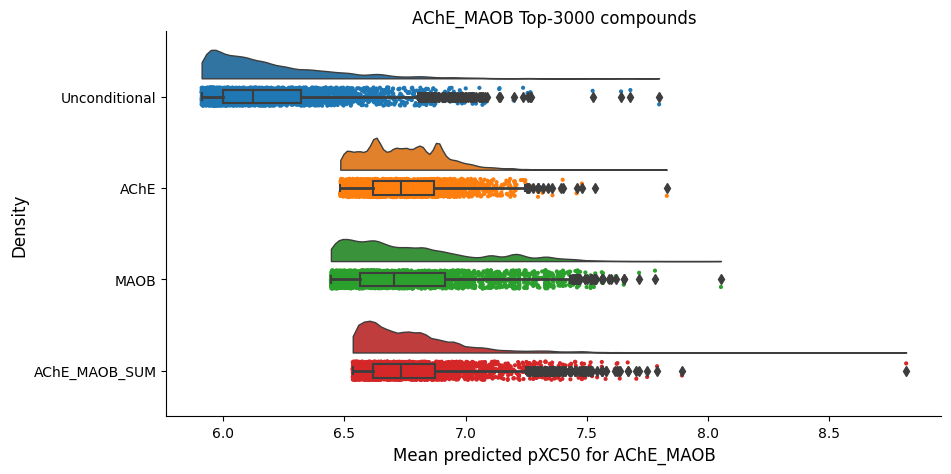

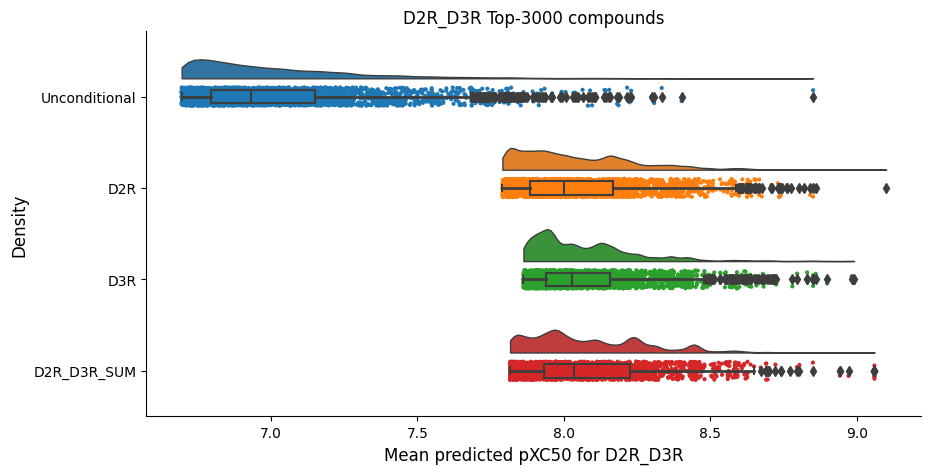

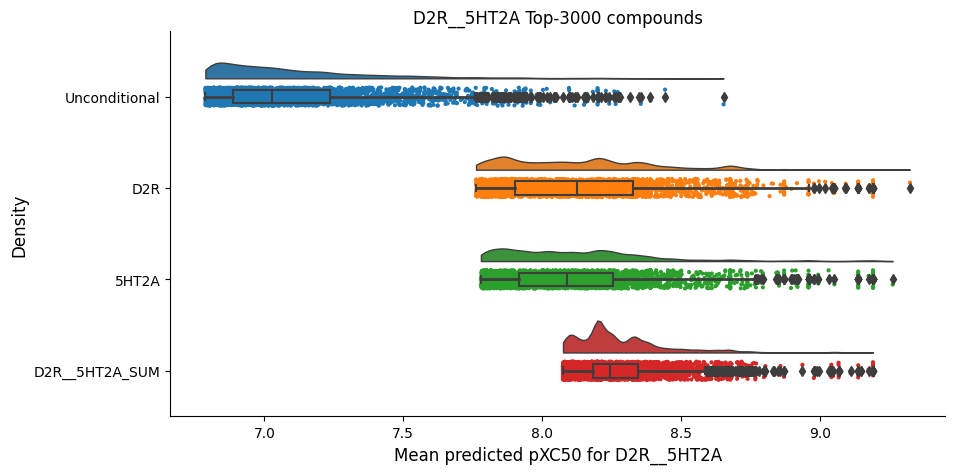

In [7]:
import ptitprince as pt

# fig, axes = plt.subplots(len(multitarget_combination), 1, figsize=(10, 5 * len(multitarget_combination)))
n = 3000
pal=list(sns.color_palette("tab10"))

for j, (ax, combination) in enumerate(zip(axes, multitarget_combination)):
    activity_column = f"{combination}_{ACT_TYPE}"
    df_list = list()
    # print(f"Combination: {activity_column}")
    fig, ax = plt.subplots(1, 1, figsize=(10, 5 * 1))


    gen_molecules = multitarget_combination[combination]["generated_molecules"]
    for gen_molecule in gen_molecules:
        # print(gen_molecule)
        # df = pd.read_csv(f'../generated_molecules/predicted_activity/{gen_molecule}_MTDD.csv')
        df = pd.read_csv(f'../generated_molecules/{EPOCHS}-epoch/predicted_activity/{gen_molecule}.csv')
        scenario = gen_molecule[1:] if gen_molecule.startswith("_") else gen_molecule
        df_filtered = df[activity_column].nlargest(n).to_frame().assign(Scenario=scenario)
        df_list.append(df_filtered)

    activities = pd.concat(df_list).reset_index()

    pt.RainCloud(data=activities, x='Scenario', y=activity_column, bw=.1, ax=ax, palette=pal, orient="h")
    # sns.kdeplot(data=df, x="pred_pXC50", bw_adjust=1, hue='Scenario',ax=axes[j], fill=True)

    ax.set_title('{} Top-{} compounds'.format(combination, n), fontsize=12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel("Density", fontsize=12)
    ax.set_xlabel(f"Mean predicted {ACT_TYPE} for {combination}", fontsize=12)

    plt.show()

# plt.tight_layout()
# plt.show()

In [8]:
for j, combination in enumerate(multitarget_combination):
    activity_column = f"{combination}_{ACT_TYPE}"
    df_list = list()

    gen_molecules = multitarget_combination[combination]["generated_molecules"]
    for gen_molecule in gen_molecules:
        df = pd.read_csv(f'../generated_molecules/{EPOCHS}-epoch/predicted_activity/{gen_molecule}.csv')
        scenario = gen_molecule[1:] if gen_molecule.startswith("_") else gen_molecule
        df_filtered = df[activity_column].nlargest(n).to_frame().assign(Scenario=scenario)
        df_list.append(df_filtered)

    activities = pd.concat(df_list).reset_index()
    pivot = activities.pivot_table(index='Scenario', values=activity_column, aggfunc=[np.mean, np.std])
    pivot = pivot.rename(columns={'mean': 'Mean', 'std': 'Std Deviation'})
    pivot = pivot.sort_values(by=('Mean', activity_column), ascending=False)

    format_str = "{:.2%}" if ACT_TYPE == "Activity" else "{:.2f}"
    # print(f"Combination: {combination}")
    display(pivot.style
                 .format(format_str)
                 .set_caption(f"Top-{n} {combination} {ACT_TYPE} statistics")
                 .background_gradient(cmap='Blues', axis=0))

,Mean,Std Deviation
,AChE_MAOB_pXC50,AChE_MAOB_pXC50
Scenario,,
MAOB,6.78,0.27
AChE_MAOB_SUM,6.78,0.21
AChE,6.75,0.16
Unconditional,6.19,0.25


,Mean,Std Deviation
,D2R_D3R_pXC50,D2R_D3R_pXC50
Scenario,,
D2R_D3R_SUM,8.08,0.20
D3R,8.07,0.17
D2R,8.05,0.20
Unconditional,7.01,0.28


,Mean,Std Deviation
,D2R__5HT2A_pXC50,D2R__5HT2A_pXC50
Scenario,,
D2R__5HT2A_SUM,8.29,0.17
D2R,8.15,0.28
5HT2A,8.12,0.26
Unconditional,7.11,0.29


In [9]:
multitarget_combination[combination]["generated_molecules"]

['Unconditional', 'D2R', '_5HT2A', 'D2R__5HT2A_SUM']

In [ ]:
# !pip install scikit-posthocs

In [ ]:
# Kruskal-Wallis H-test
from scipy.stats import kruskal
from scikit_posthocs import posthoc_dunn

print(f"The null hypothesis is that the population median of all of the groups are equal")
print(f"The alternative hypothesis is that at least one population median of the groups are different\n")


for j, combination in enumerate(multitarget_combination):
    activity_column = f"{combination}_{ACT_TYPE}"
    df_list = list()

    gen_molecules = multitarget_combination[combination]["generated_molecules"]
    for gen_molecule in gen_molecules:
        df = pd.read_csv(f'../generated_molecules/{EPOCHS}-epoch/predicted_activity/{gen_molecule}.csv')
        scenario = gen_molecule[1:] if gen_molecule.startswith("_") else gen_molecule
        df_filtered = df[activity_column].nlargest(n).to_frame().assign(Scenario=scenario)
        df_list.append(df_filtered)

    activities = pd.concat(df_list).reset_index()

    unique_scenarios = activities['Scenario'].unique()
    h, p = kruskal(*[activities[activities['Scenario'] == scenario][activity_column] for scenario in unique_scenarios])

    print(f"Combination: {combination}")
    print(f"p-value: {p:.2e}")

    if p < 0.05:
        print("Significant: Reject the null hypothesis")
        print(f"Effect size: {h:.8f}\n")
    else:
        print("Not significant: Fail to reject the null hypothesis\n")

    # Perform a post-hoc test
    posthoc = posthoc_dunn(
        activities, val_col=activity_column, group_col='Scenario', p_adjust='bonferroni'
    )

    print((posthoc < 0.01).replace({True:"true", False: "false"}).to_markdown())

### Data exploration and visualization

In [ ]:
import sys
import torch
from collections import namedtuple

sys.path.append('../cMolGPT/')

from model_auto import Seq2SeqTransformer
from scripts.smiles_utils import read_delimited_file, read_csv_file
import vocabulary as mv

mol_list0_train = list(read_delimited_file('../data/train.smi'))
mol_list0_test = list(read_delimited_file('../data/test.smi'))

mol_list1, target_list = zip(*read_csv_file('../data/excape_active_compounds.smi', num_fields=2))
mol_list = mol_list0_train
mol_list.extend(mol_list0_test) 
mol_list.extend(mol_list1)
vocabulary = mv.create_vocabulary(smiles_list=mol_list, tokenizer=mv.SMILESTokenizer())

BATCH_SIZE = 512
SRC_VOCAB_SIZE = len(vocabulary)
TGT_VOCAB_SIZE = len(vocabulary)

EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512

NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = DEVICE

args = namedtuple('args',['nhead'])(nhead=NHEAD)

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, 
                                EMB_SIZE, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE,
                                FFN_HID_DIM, args=args, emb_input_size=7)
transformer = transformer.to(device)
transformer.load_state_dict(torch.load('../models_cMolGPT/finetune.h5'))

In [ ]:
targets_to_idx = {
    "AChE": 1,
    "D2R": 2,
    # "D3R": 3,
    "_5HT2A": 4,
    "MAOB": 5,
}

target_to_key = {
    "AChE": torch.tensor([1]).to(device),
    "D2R": torch.tensor([2]).to(device),
    # "D3R": torch.tensor([3]).to(device),
    "_5HT2A": torch.tensor([4]).to(device),
    "MAOB": torch.tensor([5]).to(device),
}

target_embedding = dict()

for target in target_to_key:
    embedding = transformer.emb(target_to_key[target])
    target_embedding[target] = embedding

target_embedding["AChE"].shape

In [ ]:
# compute the cosine similarity between the target embeddings
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

similarity = dict()

for target1 in target_embedding:
    for target2 in target_embedding:
        similarity[f"{target1}_{target2}"] = cos(target_embedding[target1], target_embedding[target2])

# similarity

In [ ]:
# plot the similarity matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

similarity_matrix = np.zeros((len(target_embedding), len(target_embedding)))

for i, target1 in enumerate(target_embedding):
    for j, target2 in enumerate(target_embedding):
        similarity_matrix[i, j] = similarity[f"{target1}_{target2}"].item()

plt.figure(figsize=(8, 6), dpi=150)

sns.heatmap(
    similarity_matrix, 
    annot=True, cmap='Blues',
    xticklabels=target_embedding.keys(), 
    yticklabels=target_embedding.keys()
)

plt.title('Target Embedding Cosine Similarity')

plt.show()

In [ ]:
active_molecules_smiles = dict()
smiles_target = pd.read_csv("../data/chembl_active_compounds.smi", sep="\t", names=["SMILES", "target"])

targets_to_idx = {
    "AChE": 1,
    "D2R": 2,
    "D3R": 3,
    "_5HT2A": 4,
    "MAOB": 5,
}

for target in targets_to_idx:
    _id = targets_to_idx[target]
    smiles_target_id = smiles_target[smiles_target["target"] == _id]
    active_molecules_smiles[target] = smiles_target_id.sample(150)

active_molecules_smiles

In [ ]:
# import tanimoto bulk similarity
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import MolFromSmiles

# for each target, calculate the tanimoto similarity between the active molecules datasets
tanimoto_similarity = dict()

for target1 in targets:
    tanimoto_similarity[target1] = dict()

    for target2 in targets:
        tanimoto_similarity[target1][target2] = list()

        for smiles1 in active_molecules_smiles[target1]['SMILES']:
            mol1 = MolFromSmiles(smiles1)
            fp1 = AllChem.GetMorganFingerprint(mol1, 2)

            for smiles2 in active_molecules_smiles[target2]['SMILES']:
                mol2 = MolFromSmiles(smiles2)
                fp2 = AllChem.GetMorganFingerprint(mol2, 2)

                tanimoto_similarity[target1][target2].append(DataStructs.TanimotoSimilarity(fp1, fp2))

# plot the tanimoto similarity matrix
similarity_matrix = np.zeros((len(targets), len(targets)))

for i, target1 in enumerate(targets):
    for j, target2 in enumerate(targets):
        similarity_matrix[i, j] = np.mean(tanimoto_similarity[target1][target2])

plt.figure(figsize=(8, 6), dpi=150)

sns.heatmap(
    similarity_matrix, 
    annot=True, cmap='Blues',
    xticklabels=targets, 
    yticklabels=targets
)

plt.title('Tanimoto Similarity between Active Molecules Datasets')

#### Tree MAP

In [ ]:
all_active_molecules = pd.DataFrame()

targets = ['_5HT2A', 'AChE', 'D2R', 'MAOB']
N = 4000

for target in targets:
    mols_df = active_molecules_smiles[target]
    mols_df['target'] = target

    all_active_molecules = pd.concat([all_active_molecules, mols_df])

all_active_molecules

In [ ]:
for i, row in all_active_molecules.iterrows():
    print(row['SMILES'], row['target'])
    print(row)
    break

In [ ]:
training_mols = pd.read_csv(
    "../data/chembl_active_compounds.smi", sep="\t", names=["SMILES", "target"]
)
training_mols["target"] = training_mols["target"].replace(
    # {1: "EGFR", 2: "HTR1A", 3: "S1PR1"}
    {1: "AChE", 2: "D2R", 3: "D3R", 4: "_5HT2A", 5: "MAOB"}
)

targets = ["AChE", "D2R", "_5HT2A", "MAOB"]
ACT_TYPE = "Activity"

training_mols_ts = training_mols[training_mols["target"].isin(targets)]

for target in targets:
    transformers = pd.read_csv(f'../generated_molecules/{EPOCHS}-epoch/predicted_activity/{target}.csv')

    smiles_top_500 = transformers.drop_duplicates(subset="SMILES").nlargest(N, f"{target}_{ACT_TYPE}")

    smiles_top_500['target'] = f"{target} (generated)"
    generated_mols = smiles_top_500[["SMILES", "target"]]

    training_mols_ts = pd.concat([training_mols_ts, generated_mols])

training_mols_ts["target"].value_counts()

In [ ]:
# add multi-target generated molecules
agg = "SUM"

multi_targets = [
    (f"AChE_MAOB_{agg}", "AChE", "MAOB"),
    (f"D2R__5HT2A_{agg}", "D2R", "_5HT2A"),
    # (f"D2R_D3R_{agg}", "D2R", "D3R")
]

training_mols_mt = training_mols_ts.copy()

for (mt, t1, t2) in multi_targets:
    transformers = pd.read_csv(f'../generated_molecules/{EPOCHS}-epoch/predicted_activity/{mt}.csv')

    smiles_top_500 = transformers.drop_duplicates(subset="SMILES").nlargest(N, f"{t1}_{t2}_{ACT_TYPE}")

    smiles_top_500['target'] = f"{mt} (generated)"
    generated_mols = smiles_top_500[["SMILES", "target"]]

    training_mols_mt = pd.concat([training_mols_mt, generated_mols])

In [ ]:
training_mols_mt["target"].value_counts()

In [ ]:
# !conda install -c tmap tmap -y
# !pip install faerun mhfp

In [ ]:
import numpy as np
import tmap as tm
import scipy.stats as ss
from rdkit.Chem import AllChem
from mhfp.encoder import MHFPEncoder
from faerun import Faerun
from matplotlib.colors import ListedColormap
from tqdm import tqdm


filter_types = [
    # "AChE",
    # "MAOB",
    # "AChE (generated)",
    # "MAOB (generated)",
    # "AChE_MAOB_SUM (generated)",
    "D2R",
    "_5HT2A",
    "D2R (generated)",
    "_5HT2A (generated)",
    "D2R__5HT2A_SUM (generated)",
]

colors = {
    "AChE": "lightgreen",
    "AChE (generated)": "darkgreen",
    "D2R": "orange",
    "D2R (generated)": "darkorange",
    "_5HT2A": "blue",
    "_5HT2A (generated)": "darkblue",
    "MAOB": "#ff9a98", # "lightred",
    "MAOB (generated)": "darkred",
    # "AChE_MAOB_SUM (generated)": "#FF69B4",
    "AChE_MAOB_SUM (generated)": "#FF88FF",
    # "D2R__5HT2A_SUM (generated)": "green",
    "D2R__5HT2A_SUM (generated)": "#00ff00",
}

def main():
    """ Main funciton """
    # df = all_active_molecules
    df = training_mols_mt.query("target in @filter_types").reset_index(drop=True)

    enc = MHFPEncoder(1024)
    lf = tm.LSHForest(d=1024, l=64)

    fps = []

    for smiles in tqdm(df["SMILES"]):
        mol = AllChem.MolFromSmiles(smiles)
        fps.append(tm.VectorUint(enc.encode_mol(mol)))

    lf.batch_add(fps)
    lf.index()

    cfg = tm.LayoutConfiguration()
    cfg.node_size = 1 / 26
    cfg.mmm_repeats = 2
    cfg.sl_extra_scaling_steps = 5
    cfg.k = 20
    cfg.sl_scaling_type = tm.RelativeToAvgLength
    x, y, s, t, _ = tm.layout_from_lsh_forest(lf, cfg)

    type_labels, type_data = Faerun.create_categories(df["target"])

    cmap = ListedColormap([colors[t[1]] for t in type_labels])

    f = Faerun(view="front", coords=False, clear_color='#ffffff')
    f.add_scatter(
        "np_atlas",
        {
            "x": x,
            "y": y,
            "c": [
                type_data,
            ],
            "labels": df["SMILES"],
        },
        shader="smoothCircle",
        point_scale=2.0,
        max_point_size=20,
        legend_labels=[type_labels],
        categorical=[True],
        colormap=[cmap],
        series_title=[
            "Type",
        ],
        has_legend=True,
    )
    f.add_tree("np_atlas_tree", {"from": s, "to": t}, point_helper="np_atlas")
    f.plot(template="smiles")
    return lf

lf = main()

In [ ]:
type_labels, type_data = Faerun.create_categories(training_mols["target"])
type_labels

In [ ]:
from tqdm import tqdm

df = training_mols_mt.query("target in @filter_types").reset_index(drop=True)

enc = MHFPEncoder(1024)
# d = dimensionality of the MinHashe vectors to be added
# l = number of prefix trees used when indexing data
lf = tm.LSHForest(d=1024, l=64)

fps = []

for smiles in tqdm(df["SMILES"]):
    mol = AllChem.MolFromSmiles(smiles)
    fps.append(tm.VectorUint(enc.encode_mol(mol)))

lf.batch_add(fps)
lf.index()

# Reference: https://github.com/reymond-group/tmap/blob/c74b718a86843292ab6aad91b99196b0133faac9/src/_tmap/layout.hh#L181
cfg = tm.LayoutConfiguration()

# The size of the nodes, which affects the magnitude of their repelling force.
# Decreasing this value generally resolves overlaps in a very crowded tree.
cfg.node_size = 1 / 26

# Number of repeats of the per-level layout algorithm
cfg.mmm_repeats = 2

# Sets the number of repeats of the scaling.
cfg.sl_extra_scaling_steps = 5

# The number of nearest neighbors used to create the k-nearest neighbor graph
cfg.k = 20

# Defines the (relative) scale of the graph
cfg.sl_scaling_type = tm.RelativeToAvgLength

# Returns: The x and y coordinates of the vertices, the ids of the vertices spanning the edges, and information on the graph
x, y, s, t, graph_properties = tm.layout_from_lsh_forest(lf, cfg)

type_labels, type_data = Faerun.create_categories(df["target"])

cmap = ListedColormap([colors[t[1]] for t in type_labels])

In [ ]:
len(graph_properties.adjacency_list), len(df)

In [ ]:
# pip install networkx --force-reinstall --no-deps --upgrade --user

In [ ]:
import networkx as nx
from collections import defaultdict
import pandas as pd

# Assume G is your graph and class_dict maps each node to its class
G = nx.Graph()
class_dict = {}

for i, row in df.iterrows():
    G.add_node(i)
    class_dict[i] = row['target']

for i, adj in enumerate(graph_properties.adjacency_list):
    # adj = adj[0]
    for j in adj:
        # G.add_edge(i, j[0], weight=j[1])
        G.add_edge(i, j[0])

node_classes = class_dict
nx.set_node_attributes(G, node_classes, 'class')
print(len(G.nodes), len(G.edges))

In [ ]:
# Calculate betweenness centrality for all nodes
betweenness_centrality = nx.betweenness_centrality(G)

# Initialize a dictionary to store class pair betweenness centrality
class_pair_betweenness = defaultdict(float)

# Aggregate betweenness centrality by class pairs
for node, centrality in betweenness_centrality.items():
    node_class = G.nodes[node]['class']
    for neighbor in G.neighbors(node):
        neighbor_class = G.nodes[neighbor]['class']
        if node_class != neighbor_class:  # Only consider inter-class pairs
            class_pair = tuple(sorted([node_class, neighbor_class]))
            class_pair_betweenness[class_pair] += centrality

# Output the betweenness centrality for each class pair
for class_pair, centrality in class_pair_betweenness.items():
    print(f"Betweenness centrality between classes {class_pair}: {centrality}")

In [ ]:
# convert class_pair_betweenness into a matrix
targets = df["target"].unique()

class_pair_betweenness_matrix = np.zeros((len(targets), len(targets)))

for i, target1 in enumerate(targets):
    for j, target2 in enumerate(targets):
        class_pair_betweenness_matrix[i, j] = class_pair_betweenness[(target1, target2)]

plt.figure(figsize=(8, 6), dpi=150)
sns.heatmap(
    class_pair_betweenness_matrix,
    annot=True,
    cmap='Blues',
    xticklabels=targets,
    yticklabels=targets
)

plt.title('Betweenness Centrality between Target Classes')

plt.show()

In [ ]:
def compute_class_metrics(G, node_classes):
    class_metrics = {}
    classes = set(node_classes.values())
    
    for class_name in classes:
        class_nodes = [n for n in G.nodes if G.nodes[n]['class'] == class_name]
        class_edges = G.subgraph(class_nodes).number_of_edges()
        possible_intra_class_edges = len(class_nodes) * (len(class_nodes) - 1) / 2
        intra_class_density = class_edges / possible_intra_class_edges if possible_intra_class_edges > 0 else 0
        
        inter_class_edges = 0
        possible_inter_class_edges = 0
        
        for other_class_name in classes:
            if other_class_name != class_name:
                other_class_nodes = [n for n in G.nodes if G.nodes[n]['class'] == other_class_name]
                possible_inter_class_edges += len(class_nodes) * len(other_class_nodes)
                inter_class_edges += len([e for e in G.edges if (G.nodes[e[0]]['class'], G.nodes[e[1]]['class']) in [(class_name, other_class_name), (other_class_name, class_name)]])
        
        inter_class_density = inter_class_edges / possible_inter_class_edges if possible_inter_class_edges > 0 else 0
        
        class_metrics[class_name] = {
            'intra_class_density': intra_class_density,
            'inter_class_density': inter_class_density
        }
    
    return class_metrics

# Compute modularity contribution
def compute_class_modularity(G, node_classes):
    modularity_dict = {}
    communities = [list(filter(lambda x: node_classes[x] == c, G.nodes)) for c in set(node_classes.values())]
    modularity = nx.algorithms.community.quality.modularity(G, communities)
    
    for community in communities:
        subgraph = G.subgraph(community)
        class_name = node_classes[community[0]]
        subgraph_modularity = nx.algorithms.community.quality.modularity(subgraph, [community])
        modularity_dict[class_name] = subgraph_modularity
    
    return modularity, modularity_dict

class_metrics = compute_class_metrics(G, node_classes)
modularity, class_modularity_dict = compute_class_modularity(G, node_classes)

df = pd.DataFrame(class_metrics).T

print("Class Metrics:")
for class_name, metrics in class_metrics.items():
    print(f"Class {class_name}:")
    print(f"  Intra-class Density: {metrics['intra_class_density']}")
    print(f"  Inter-class Density: {metrics['inter_class_density']}")

print(f"Overall Modularity: {modularity}")
print("Class Modularity Contributions:")
for class_name, mod_value in class_modularity_dict.items():
    print(f"  Class {class_name} Modularity: {mod_value}")

In [ ]:
print(df.assign(
    Intra_class_Density=df['intra_class_density'].map('{:.2e}'.format),
    Inter_class_Density=df['inter_class_density'].map('{:.2e}'.format)
).drop(columns=['intra_class_density', 'inter_class_density']).to_markdown())

In [ ]:
def compute_conductance(G, node_classes):
    conductance_dict = {}
    classes = set(node_classes.values())
    
    for class_name in classes:
        # Nodes in the current class
        class_nodes = [n for n in G.nodes if G.nodes[n]['class'] == class_name]
        
        # Subgraph induced by class nodes
        subgraph = G.subgraph(class_nodes)
        
        # Number of edges within the class
        internal_edges = len(list(subgraph.edges()))
        
        # Total number of edges connected to class nodes
        total_edges = sum([G.degree(n) for n in class_nodes]) / 2
        
        # Number of edges connecting class nodes to nodes outside the class
        boundary_edges = sum([len([e for e in G.edges(n) if e[0] in class_nodes or e[1] in class_nodes]) for n in class_nodes]) / 2 - internal_edges
        
        # Conductance calculation
        if total_edges == 0:
            conductance = 0
        else:
            conductance = boundary_edges / total_edges
        
        conductance_dict[class_name] = conductance
    
    return conductance_dict

# Compute conductance for each class
conductance = compute_conductance(G, node_classes)

# Print the conductance values
for class_name, value in conductance.items():
    print(f'Class {class_name} Conductance: {value}')

In [ ]:
# Initialize a dictionary to store edges between class pairs
class_pair_edges = defaultdict(lambda: defaultdict(int))
total_edges_per_class_pair = defaultdict(lambda: defaultdict(int))

# Count edges between class pairs
for node in G.nodes():
    node_class = class_dict[node]
    for neighbor in G.neighbors(node):
        neighbor_class = class_dict[neighbor]
        total_edges_per_class_pair[node_class][neighbor_class] += 1
        if node_class != neighbor_class:
            class_pair_edges[node_class][neighbor_class] += 1
            class_pair_edges[neighbor_class][node_class] += 1  # Since it's an undirected graph

# Calculate neighboring index for each pair of classes
neighboring_index = defaultdict(lambda: defaultdict(float))
for class_i in total_edges_per_class_pair:
    for class_j in total_edges_per_class_pair[class_i]:
        if total_edges_per_class_pair[class_i][class_j] > 0:
            neighboring_index[class_i][class_j] = class_pair_edges[class_i][class_j] / total_edges_per_class_pair[class_i][class_j]

print("Neighboring Index for each pair of classes:")
for class_i in neighboring_index:
    for class_j in neighboring_index[class_i]:
        print(f"({class_i}, {class_j}): {neighboring_index[class_i][class_j]:.2f}")

In [ ]:
import networkx as nx
from collections import defaultdict

# Assume G is your graph and class_dict maps each node to its class
# G = nx.Graph()
# class_dict = {}

# Add edges and node classes to the graph G and class_dict...

# Initialize dictionaries to store volume and cut size for each class
class_volume = defaultdict(int)
class_cut = defaultdict(int)

# Calculate volume and cut size for each class
for node in G.nodes():
    node_class = class_dict[node]
    for neighbor in G.neighbors(node):
        neighbor_class = class_dict[neighbor]
        class_volume[node_class] += 1  # Increment volume for the node's class
        if node_class != neighbor_class:
            class_cut[node_class] += 1  # Increment cut size if neighbor is in a different class

# Compute conductance for each class
conductance = {}
for cls in class_volume:
    if class_volume[cls] > 0:
        conductance[cls] = class_cut[cls] / min(class_volume[cls], 2 * (len(G.edges) - class_volume[cls]))

# Print conductance for each class
print("Conductance for each class:")
for cls, cond in conductance.items():
    print(f"Class {cls}: {cond:.4f}")

In [ ]:
def compute_pairwise_conductance(G, class_dict):
    # Get unique classes
    classes = list(set(class_dict.values()))
    
    # Initialize dictionaries to store volumes and cut sizes for class pairs
    class_pair_cut = defaultdict(lambda: defaultdict(int))
    class_pair_volume = defaultdict(lambda: defaultdict(int))
    
    # Calculate volume and cut size for each pair of classes
    for node in G.nodes():
        node_class = class_dict[node]
        for neighbor in G.neighbors(node):
            neighbor_class = class_dict[neighbor]
            class_pair_volume[node_class][neighbor_class] += 1
            if node_class != neighbor_class:
                class_pair_cut[node_class][neighbor_class] += 1

    # Compute conductance for each pair of classes
    conductance_matrix = pd.DataFrame(index=classes, columns=classes, dtype=float)

    for class_i in classes:
        for class_j in classes:
            if class_pair_volume[class_i][class_j] > 0:
                cut = class_pair_cut[class_i][class_j]
                volume_i = sum(class_pair_volume[class_i].values())
                volume_j = sum(class_pair_volume[class_j].values())
                conductance_matrix.at[class_i, class_j] = cut / min(volume_i, volume_j)
            else:
                conductance_matrix.at[class_i, class_j] = None

    return conductance_matrix

# Compute pairwise conductance for each class
conductance_matrix = compute_pairwise_conductance(G, class_dict)

# Print conductance matrix
print("Pairwise Conductance Matrix:")
sns.heatmap(conductance_matrix, annot=True, cmap='Blues')

In [ ]:
# Compute the clustering coefficient for each node
node_clustering = nx.clustering(G)

# Initialize a dictionary to store the clustering coefficients for each class
class_clustering = defaultdict(list)

# Group clustering coefficients by class
for node, clustering in node_clustering.items():
    node_class = class_dict[node]
    class_clustering[node_class].append(clustering)

# Calculate the average clustering coefficient for each class
avg_class_clustering = {cls: sum(coeffs) / len(coeffs) for cls, coeffs in class_clustering.items()}

# return avg_class_clustering

# Compute clustering coefficients for each class
# avg_class_clustering = compute_clustering_coefficient(G, class_dict)

# Print the average clustering coefficient for each class
print("Average Clustering Coefficient for each class:")
for cls, coeff in avg_class_clustering.items():
    print(f"Class {cls}: {coeff:.2e}")